In [1]:
import networkx   # more tools for graphs
import numpy   # scientific computation and variable formats library
import matplotlib   # plotting 
import matplotlib.pyplot   # specific plotting
import matplotlib.animation as animation    # joining plots in animations
import matplotlib.patches as patches   # adding legends to matplotlib charts
import os.path   # interaction with  files and filenames
import pandas   # library for loading and organising data
import datetime   # calendar and dates handling
import re   # I'm using regex, apologies

# using xlrd

Please notice, to open jupyter in custom directory use:
>jupyter notebook --notebook-dir=[your_directory]

Expecting file hierarchy:
    <ul>root/
        <li>Antarctica_research_2020/
            <ul>.git/</ul>
            <ul>.gitignore</ul>
            <ul>readme.md</ul>
            <ul>notebook.ipynb</ul>
            <ul>img/
                    <ul>example_entry.jpg</ul>
            </ul>
    </li>
        <li>data/
            <ul>Sesja 1.xlsx</ul>
            <ul>.</ul>
            <ul>.</ul>
            <ul>Sesja 26.xlsx</ul></li>
    </ul>

## 1. Introduction

![An example chart filled by person no. 1](img/example_entry.jpg)

Above, you can see an example entry chart, filled up on 29.12.78.
Each of 21 examined people had been filling such charts during every session, which took place every two weeks.
On a chart, an examined person marked his subjective possition and positions of others, as he saw fit.
As the experiment continued, people changed their views about each other, and thus changed the positions marked
on those charts. This, albeit simple method give us an insight about how social standings of each individual
changed in regards to other interconnected changes.

### My goal is to answer some very basic questions about how those people relations shaped 40 years ago when they were stationed near the south pole, on Antarctica's coast: 

<ol>
  <li>Introduction</li>
  <li>Glossary of terms used</li>
  <li>Load the data from excel as-is</li>
  <li>Define objects 'Session' and 'Person' to hold the data in useful form, organised by sessions, or by men</li>
  <li>Find general tendency how people marked other on charts during sessions</li>
  <li>Find general tendency how people were marked by others</li>
  <li>Create weighted graphs of relations, one for each session for further use</li>
  <li>Find how graph centrality changed over the sessions</li>
  <li>Define and investigate the summary graph</li>
  <li>Find what groups did people created</li>
  <li>Who was most infuential among the men?</li>
  <li>Group persistence index</li>
  <li>How influence shaped and how was it connected to input data patterns?</li>
  <li>How one's view about others shaped the view others had about him?</li>
  <li>A look on statistical significances</li>
  <li>Speculation: space mission predictions</li>
  <li>Summary and insights</li>
</ol>

## 2. Glossary of terms used
As I was adding more sections and introduced more terms in this notebook, I was asked to gather all terms in one place. When used, I revisit those concepts and give links to definitions. Below is a list of used concepts in order of apperance:


<b>distance</b> - Men stationed on <a href="https://en.wikipedia.org/wiki/Henryk_Arctowski_Polish_Antarctic_Station">Arctowski research station</a> during the examination marked their subjective possition and positions of other men on charts, as they saw fit. Check the above chart for reference. Each possible position of a marking has two coordinates. Given this coordinates I calculate <a href="https://en.wikipedia.org/wiki/Euclidean_distance">Euclidean distances</a> between each marking, for each man, for each session. Because of this, for each session a man has distances from him to other men and also from every other man to himself (known from respective other charts).

<b>closeness</b> - the term is used interchangeably with closeness centrality

<a href="https://en.wikipedia.org/wiki/Closeness_centrality"><b>closeness centrality</b></a> - a number between 0 and 1 being a ratio of the fraction of actors in the group who are reachable, to the average distance. This number describes how central is particular node in a graph - the more central a node is, the closer it is to all other nodes. In this notebook case all nodes are connected to each other, however they vary in distance to each other (each man represented by a node is linked by weighted edge to each other man - the weigth is a subjective distance how far man one felt himself from man two). In this observations case, closeness centrality varied between 0.15 and 0.35. The bigger value, the more central is particular man. In this case, the more central means the man was more <a href="https://en.wikipedia.org/wiki/Centrality#Betweenness_centrality">in between</a> other men. Check <a href="https://www.researchgate.net/publication/328954103_Application_of_Graph_Theory_in_Social_Media">"Application of Graph Theory in Social Media"</a> by Anwesha Chakraborty, Trina Dutta, Sushmita Mondal and Asoke Nath for more details.

<b>outgoing relation</b> - the distance from particular man to other man, calculated from particular man's chart

<b>incoming relation</b> - the distance from other man to a particualr one, calculated from other men charts

<b>relation</b> - in this case a relation is represented by an edge in a graph. Edges are weighted which means a relation becomes a quantitive value

<b>distance change tendency</b> - Having calculated distances for people for sessions, the tendency is a metric telling how much the value changed over time. Value of change above zero means that there is tendency for people to be see themselves far away from others - the distance value was higher with each session. Check <a href="https://www.sciencedirect.com/science/article/pii/S0378873318300170">"The Emergence and Stability of Groups in Social Networks"</a> by Christoph Stadtfel, Károly Takács and András Vörös for more examples of how tendencies might be used in social networks.

<b>group</b> - I understand a group in terms of <a href="https://en.wikipedia.org/wiki/Social_group">social groups</a>. Please check the link to wikipedia's article for elaborative definition. A group is a number of people (or nodes in a graph)  that are gathered together. The tricky part is to decide when given people are grouped, and when they are not - and there are many ways of mathematical interpretation of this problem. <a href="https://arxiv.org/abs/0906.0612">"Community detection in graphs"</a> by Santo Fortunato touches the problem nicely.

<b>graph density</b> - a ratio of the number of edges to the number of vertices in the graph - maximal density is 1 and the minimal density is 0 (max density of 1 when all vertices are connected with each other). The density is 0 for a graph without edges and 1 for a complete graph. Please notice that the density is not relevant to the session's graphs - graphs where all nodes are connected (regardless of weigths of edges).

<b>clique</b> - "a subset whose vertices are all adjacent to each other. In social network analysis, a clique is a maximal sub-graph, whereas in graph theory it is common to call cliques also non-maximal subgraphs. Triangles are the simplest cliques, and are frequent in real networks. But larger cliques are less frequent." - <a href="https://arxiv.org/abs/0906.0612">"Community detection in graphs"</a> by Santo Fortunato<br>
Pleace notice that under this definition, each <i>session graph</i> is a clique.
In practice, for each node in <i>group graphs</i> (not for sessions) I get a list of cliques on which particular node is listed and process those lists further - and this leads to an another term:

<b>overlaping clique</b> - Considering the lists of nodes which are part of a clique it may happen that some nodes are indicated on more than one list. This may lead to a situation when a node is counted more than once (see examples from point no. 10)

<b>clustering</b> - The local clustering of each node in graph is the fraction of triangles that actually exist over all possible triangles in its neighborhood. The average clustering coefficient of a graph is the mean of local clusterings.

<b>group persistence</b> - "How groups emerge and remain stable in various contexts is an important question in the social
sciences, as group cohesion and group boundaries are linked to crucial societal outcomes such as segregation, group inequalities, differences in information access, and political polarization. Within social groups, individuals typically form strong positive ties, such as friendship. The interpersonal relations that connect individuals who are members of different groups, however, tend to be weaker, neutral, or even negative." - as stated in <a href="https://www.sciencedirect.com/science/article/pii/S0378873318300170">"The Emergence and Stability of Groups in Social Networks"</a> by Christoph Stadtfel, Károly Takác and András Vörös

<b>influence</b> - by <a href="https://en.wikipedia.org/wiki/Social_influence">influence</a> I understand a simple number of mutual connections (as previously defined). The most influential man would have the most mutual connections - best relations with the most other men. In fact, this does not necessarily mean he <i> was influential</i> - he could just be most open and friendly to others. Beside this notebook, influence is much more complicated term.

<b>correlation</b> - "correlation or dependence is any statistical relationship, whether causal or not, between two random variables or bivariate data. In the broadest sense correlation is any statistical association, though it commonly refers to the degree to which a pair of variables are linearly related" - <a href="https://en.wikipedia.org/wiki/Correlation_and_dependence">Wikipedia</a>

<b>standard deviation</b> - the standard deviation is a measure of the amount of variation or dispersion of a set of values.[1] A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range - <a href="https://en.wikipedia.org/wiki/Standard_deviation">Wikipedia</a>

<b>statistical significance</b> - please read <a href="https://hbr.org/2016/02/a-refresher-on-statistical-significance">this article</a>


In [2]:
# Let me write in advantage examined people occupations:
ppl_professions = {1: "fisherman",
                  2: "cook",
                  3: "medic",
                  4: "deputy technical manager",
                  5: "carpenter",
                  6: "driver",   # UWAGA - nr 6 przybył na stację 25.04.79r -> present from session no. 10
                  7: "technician",
                  8: "chemist",
                  9: "meteorologist",
                  10: "ichthyologist",   # study of fish
                  11: "magnetologist",
                  12: "seismologist",
                  13: "biologist",
                  14: "electrician",
                  15: "radiotelegraphist",
                  16: "psychologist",
                  17: "electronics engineer",
                  18: "meteorologist",
                  19: "microbiologist",
                  20: "parasitologist",
                  21: "botanist"   # data is missing for sessions 1-4
                  }

## 3. First, let me load and adjust the given data:

In [3]:
data_path = "../data/"
file_list = [name for name in os.listdir(data_path)]
print(file_list)

['Sesja 1.xlsx', 'Sesja 10.xlsx', 'Sesja 11.xlsx', 'Sesja 12.xlsx', 'Sesja 13.xlsx', 'Sesja 14.xlsx', 'Sesja 15.xlsx', 'Sesja 16.xlsx', 'Sesja 17.xlsx', 'Sesja 18.xlsx', 'Sesja 19.xlsx', 'Sesja 2.xlsx', 'Sesja 20.xlsx', 'Sesja 21.xlsx', 'Sesja 22.xlsx', 'Sesja 23.xlsx', 'Sesja 24.xlsx', 'Sesja 25.xlsx', 'Sesja 26.xlsx', 'Sesja 3.xlsx', 'Sesja 4.xlsx', 'Sesja 5.xlsx', 'Sesja 6.xlsx', 'Sesja 7.xlsx', 'Sesja 8.xlsx', 'Sesja 9.xlsx']


In [4]:
# Sessions order is important, let me get sorted file info
sorted_filenames = dict()
for name in file_list:
    list_of_digits = list(map(int, filter(str.isdigit, name)))
    sorted_filenames[name] = list_of_digits[0] if len(list_of_digits) == 1 else list_of_digits[1] + list_of_digits[0]*10
sorted_filenames = sorted(sorted_filenames.items(), key=lambda el: el[1])
sorted_filenames = {val: key for key, val in sorted_filenames}
print("Filenames properly ordered: ")
print(sorted_filenames)

Filenames properly ordered: 
{1: 'Sesja 1.xlsx', 2: 'Sesja 2.xlsx', 3: 'Sesja 3.xlsx', 4: 'Sesja 4.xlsx', 5: 'Sesja 5.xlsx', 6: 'Sesja 6.xlsx', 7: 'Sesja 7.xlsx', 8: 'Sesja 8.xlsx', 9: 'Sesja 9.xlsx', 10: 'Sesja 10.xlsx', 11: 'Sesja 11.xlsx', 12: 'Sesja 12.xlsx', 13: 'Sesja 13.xlsx', 14: 'Sesja 14.xlsx', 15: 'Sesja 15.xlsx', 16: 'Sesja 16.xlsx', 17: 'Sesja 17.xlsx', 18: 'Sesja 18.xlsx', 19: 'Sesja 19.xlsx', 20: 'Sesja 20.xlsx', 21: 'Sesja 21.xlsx', 22: 'Sesja 22.xlsx', 23: 'Sesja 23.xlsx', 24: 'Sesja 24.xlsx', 25: 'Sesja 25.xlsx', 26: 'Sesja 26.xlsx'}


In [5]:
# Loading data
data_dict = dict()
for key, val in sorted_filenames.items():
    data_dict[key] = pandas.read_excel(data_path + val, header=None, dtype=object)

In [6]:
rand_int = int(numpy.random.rand() * 26) + 1
print("First four rows of source data from session no. " + str(rand_int))
data_dict[rand_int].head(4)
# An example:

First four rows of source data from session no. 11


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,NaN,Pozycja osoby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N = 21,NaN,NaN,1979-05-20 00:00:00,NaN,NaN,NaN,ZIM11,NaN,NaN
1,Nr O.B.,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2,1,2918,3118,3126,3124,2922,2618,2720,2715,2915,...,3016,2716,2824,3024,2623,2520,2516,2619,2713,2513
3,2,2511,2201,2416,1608,2927,3521,2113,1920,2322,...,3437,1734,3429,2507,2820,1419,1725,2736,1123,1228


## 4. Define objects 'Session' and 'Person'
During my investigation I'll transform the data into various objects.
First, let me organise the data in two python objects by sessions and by people.(session -> data recording occuring every two week). <br>
    Session will hold data in respect to each source data file, organising entries into lists of coordinates marked by examined people - one list for one man for each session.<br>
    Person will organise data in respect to a single individual. Each* individual hold data for all 26 sessions, for convienience repeated in several arrangements.
    
*except mr. 6th, since he arrived later

In [7]:
class Session(object):
    def __init__(self, raw_session_data):
        self.date = self.find_date(raw_session_data)
        self.relations = self.get_relations(raw_session_data) # dictionary of lists of tuples - column_number : [(x1, y1), (x2, y2), ...]
    
    def get_relations(self, raw_session_data) -> dict:
        rels = dict()
        col_no = len(ppl_professions)
        rels = {x: [] for x in ppl_professions.keys()}
        for person in range(2, col_no + 2):
            for entry in range(1, col_no + 1):
                string_value = str(raw_session_data.iloc[person, entry])
                subject_no = raw_session_data.iloc[person, 0]
                data_point = self.tuple_from_string(string_value)
                rels[subject_no].append(data_point)
        return rels
    
    def tuple_from_string(self, string) -> tuple:
        if string == 'nan':
            return None
        elif len(string) == 4:
            x = int(string[1]) + int(string[0]) * 10
            y = int(string[3]) + int(string[2]) * 10
            return (x, y)
        elif len(string) == 3:
            x = int(string[0])
            y = int(string[2]) + int(string[1]) * 10
            return (x, y)
        else:
            return None
    
    def find_date(self, raw_session_data) -> str:
        for key, col in raw_session_data.iteritems():
            for val in col:
                regex = re.search(r"\d{1,2}.\d{1,2}.\d{4}|\d{4}.\d{1,2}.\d{1,2}", str(val))
                if regex:
                    return regex.group()
                
    def __str__(self):
        random = int(numpy.random.rand() * len(ppl_professions))
        return "Session from " + self.date + " example entry: " + str(self.relations[random]) + " for " + str(random)

Session from 1979-12-02 example entry: [(28, 34), (24, 37), (1, 1), (1, 11), (1, 24), (20, 13), (1, 40), (20, 20), (12, 14), (27, 39), (34, 38), (13, 29), (28, 19), (22, 27), (23, 13), (29, 18), (7, 14), (24, 25), (16, 36), (27, 14), (27, 24)] for 8

The shapes for example entries from last session, above for biologist, below for meteorologist: 


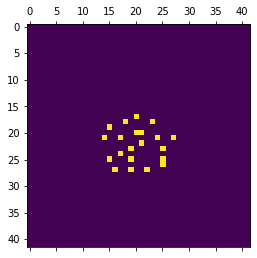

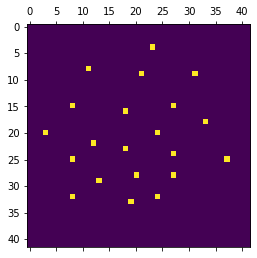

In [8]:
session_data = [Session(e) for e in data_dict.values()]
# An example entry in text:
print(session_data[-2])
print()   # newline
# An example entries in chart:
print("The shapes for example entries from last session, above for biologist, below for meteorologist: ")
relations_in_points = session_data[-1].relations[13]
x_max = y_max = 42
relations_in_matrix = [[0 for y in range(y_max)] for x in range(x_max)]
for x, y in relations_in_points:
    relations_in_matrix[x][y] = 1    
matplotlib.pyplot.matshow(relations_in_matrix, 1)

relations_in_points = session_data[-1].relations[9]
x_max = y_max = 42
relations_in_matrix = [[0 for y in range(y_max)] for x in range(x_max)]
for x, y in relations_in_points:
    relations_in_matrix[x][y] = 1    
matplotlib.pyplot.matshow(relations_in_matrix, 2)

matplotlib.pyplot.show()

Notice how different is the way how two men marked their charts. What is also not without significance is that marking somebody as a close one does not necessarily mean he reciprocated this closeness. This is an important point which I will refer to in further observations (and verify in the significances' section).

In [9]:
class Person(object):
    def __init__(self, person_no, particular_person_profession, session_data):
        self.person_no = person_no
        self.profession = particular_person_profession
        self.sessions_dict = self.get_all_relations(session_data)
        self.relations_vector = self.get_all_relative_vectors(self.sessions_dict)
        self.distances = self.get_all_distances(self.relations_vector)
        
    def get_all_relations(self, session_data) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no in out_dict.keys():
            out_dict[no] = session_data[no - 1].relations[self.person_no]
        return out_dict
    
    def get_all_relative_vectors(self, relations) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in relations.items():
            for relation in session:
                if relation is not None and session[self.person_no - 1] is not None:
                    out_dict[no].append((relation[0] - session[self.person_no - 1][0], relation[1] - session[self.person_no - 1][1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def get_all_distances(self, vectors) -> dict:
        out_dict = {x: [] for x in sorted_filenames.keys()}
        for no, session in vectors.items():
            for vector in session:
                if vector is not None:
                    out_dict[no].append(self.calc_distance(vector[0], vector[1]))
                else:
                    out_dict[no].append(None)
        return out_dict
    
    def calc_distance(self, a, b) -> float:
        return numpy.sqrt(a ** 2 + b ** 2)
    
    def __str__(self):
        rand_session = int(numpy.random.rand() * 26)
        return "No. " + str(self.person_no) + " being " + self.profession + " with distances: " + str(self.distances[rand_session]) + " for session " + str(rand_session)

In [10]:
people_data = [Person(no, profession, session_data) for no, profession in ppl_professions.items()]
# An example:
rand_ppl = int(numpy.random.rand() * 21)
print("An example entry for a man, with euclidean distances for each coworker. Number on position relating to self is always 0.")
print()   # newline
print(people_data[rand_ppl])

An example entry for a man, with euclidean distances for each coworker. Number on position relating to self is always 0.

No. 2 being cook with distances: [8.06225774829855, 0.0, 10.198039027185569, 9.899494936611665, None, None, 9.219544457292887, 13.601470508735444, 16.278820596099706, 3.1622776601683795, 19.4164878389476, 26.570660511172846, 13.038404810405298, 20.808652046684813, 3.605551275463989, 15.811388300841896, 20.223748416156685, 15.652475842498529, 25.317977802344327, 15.620499351813308, 21.470910553583888] for session 7


## 5. Having defined sessions and persons, now I want to get some insights about the people's relations:

#### What was general tendency of marking others on charts?

By general tendency I understand a value telling me if <b>people were viewing others</b> as closer or more far away after time passed. I'm going to get a mean distance for each session for each person and see how those changed, and check the slope of linear approximation of given sessions' mean values.

Later I call it an <i>outgoing relation</i>.

In [11]:
mean_distance_per_session_per_man = [[(sum(filter(None, distances))/(len(distances))) if len(distances) != 0 else None for distances in man.distances.values()] for man in people_data]
mean_distance_slope_for_man = []
mean_distances_for_man = []
mean_values_of_mean_distance_for_man = []
for y in mean_distance_per_session_per_man:
    y = list(filter(None, y))
    if y:
        x = range(len(y))
        mean_distances_for_man.append(y)
        a, b = numpy.polyfit(x, y, deg=1)   # y = a * x + b (approximated by least squares polynomial fit)
        mean_distance_slope_for_man.append(a)
        mean_values_of_mean_distance_for_man.append(numpy.mean(y))
        
findings = zip(ppl_professions.values(), mean_values_of_mean_distance_for_man, mean_distance_slope_for_man)
findings = sorted(findings, key = lambda x: x[1])

print("Occupation, mean distance and distance change tendency (above zero being more distancing)")
print()
for entry in findings:
    print(f"{entry[0]:25} | {entry[1]:8.4f} | {entry[2]:8.4f}")
print()
print("Average change for mean distance slope is ", numpy.mean(mean_distance_slope_for_man))
print("Standard deviation for mean distance slope is ", numpy.std(mean_distance_slope_for_man))

Occupation, mean distance and distance change tendency (above zero being more distancing)

biologist                 |   4.3112 |   0.0771
medic                     |   4.4377 |   0.0976
electronics engineer      |   4.5907 |   0.0967
carpenter                 |   4.6362 |   0.0078
microbiologist            |   4.9219 |   0.0203
meteorologist             |   4.9442 |   0.0114
fisherman                 |   5.1634 |  -0.0619
ichthyologist             |   5.7443 |   0.0561
psychologist              |   6.3800 |   0.0630
deputy technical manager  |   6.6229 |   0.1470
parasitologist            |   8.0027 |   0.3074
driver                    |   8.1935 |  -0.2298
seismologist              |   9.1061 |   0.1680
technician                |   9.3022 |  -0.0019
botanist                  |   9.6682 |  -0.0811
magnetologist             |  10.0467 |  -0.1854
meteorologist             |  10.1716 |   0.2147
electrician               |  11.1674 |  -0.0010
chemist                   |  12.3395 |  -0.03

Average change for mean distance slope is slighty positive, suggesting people felt more distant over time.<br>
See following plots to better imagine what slope mean - remember it's an abstraction of relations tendency.<br>
Let me plot the mean, the "range" of standard deviation, and see how those slopes fit in:

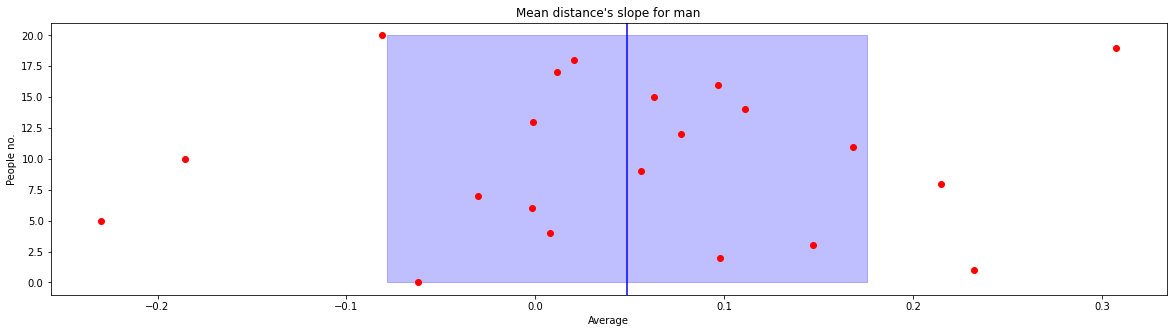

In [12]:
find_max = max(mean_distance_slope_for_man)
find_min = min(mean_distance_slope_for_man)

mean = numpy.mean(mean_distance_slope_for_man)
std_lim_1 = mean - numpy.std(mean_distance_slope_for_man)
std_lim_2 = mean + numpy.std(mean_distance_slope_for_man)
y = list(range(21))

matplotlib.pyplot.figure(figsize=(20, 5))
matplotlib.pyplot.title("Mean distance's slope for man")
matplotlib.pyplot.plot(mean_distance_slope_for_man, range(len(mean_distance_slope_for_man)), 'ro')
matplotlib.pyplot.ylabel("People no.")
matplotlib.pyplot.xlabel("Average")
matplotlib.pyplot.axvline(numpy.mean(mean_distance_slope_for_man), color='b')
matplotlib.pyplot.fill_betweenx(y, x1=std_lim_1, x2=std_lim_2,
                color='blue', alpha=0.25)
matplotlib.pyplot.show()

Let's see plots of the average distances for each session, for each person:


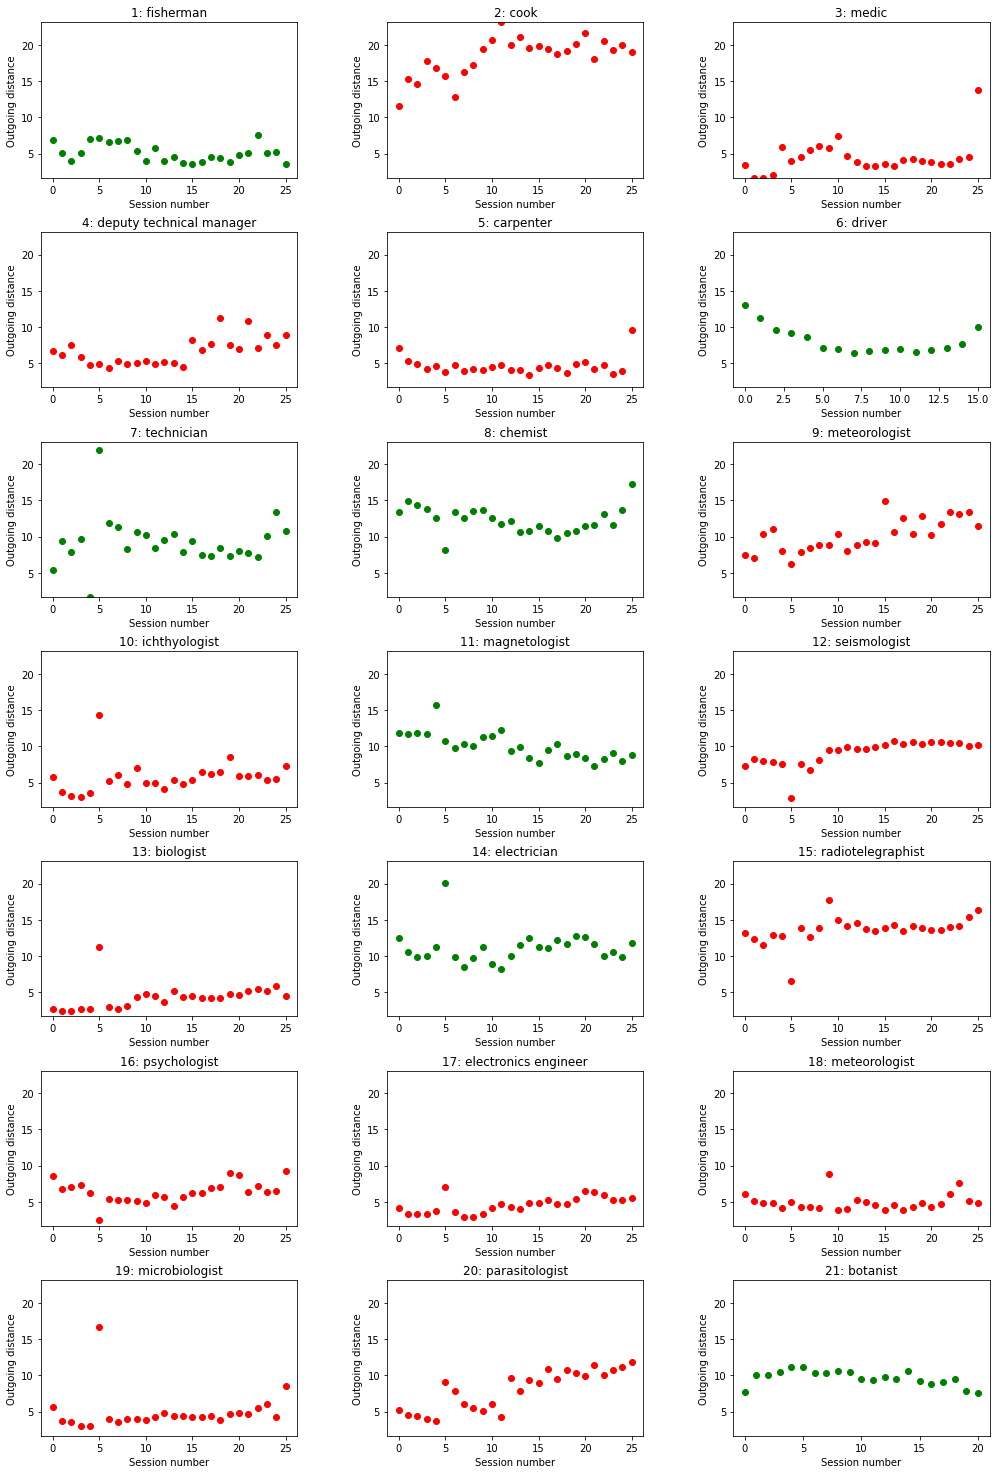

In [13]:
find_max = max([max(el) for el in mean_distances_for_man])
find_min = min([min(el) for el in mean_distances_for_man])
matplotlib.pyplot.figure(figsize=(17, 26))
plot_rows_no = 7
plot_cols_no = 3

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    matplotlib.pyplot.ylabel("Outgoing distance")
    matplotlib.pyplot.xlabel("Session number")
    plot_color = 'go' if mean_distance_slope_for_man[man - 1] < 0 else 'ro'
    matplotlib.pyplot.plot(mean_distances_for_man[man - 1], plot_color) # -1 since I index plot_ppl from 0    
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.subplots_adjust(hspace=0.35, wspace=0.35)
print("Let's see plots of the average distances for each session, for each person:")
matplotlib.pyplot.show()

## 6. What was general tendency how one was viewed by others?

Simillar to the above, I'm going to check how people were viewed by the others - I want to plot the average distance from people to the particular person by each session.

I'll refer to this as an <i>incoming relation</i>.

In [14]:
distances_per_session_per_man = [[dists for dists in person.distances.values()] for person in people_data]
average_incoming_distance_per_session_per_man = [[[] for dists in person.distances.values()] for person in people_data]

for i_m, man in enumerate(distances_per_session_per_man):
    for i_s, session in enumerate(man):
        for i_d, distance in enumerate(session):
            average_incoming_distance_per_session_per_man[i_m][i_s].append(distances_per_session_per_man[i_d][i_s][i_m])

for i_m, man in enumerate(distances_per_session_per_man):
    for i_s, session in enumerate(man):
        average_incoming_distance_per_session_per_man[i_m][i_s] = list(filter(None, average_incoming_distance_per_session_per_man[i_m][i_s]))
        if average_incoming_distance_per_session_per_man[i_m][i_s]:
            average_incoming_distance_per_session_per_man[i_m][i_s] = numpy.mean(average_incoming_distance_per_session_per_man[i_m][i_s])
        else:
            average_incoming_distance_per_session_per_man[i_m][i_s] = None

for i_m, man in enumerate(average_incoming_distance_per_session_per_man):
    average_incoming_distance_per_session_per_man[i_m] = list(filter(None, average_incoming_distance_per_session_per_man[i_m]))

average_incoming_distance_per_man = {man: numpy.mean(average_incoming_distance_per_session_per_man[man-1]) for man in ppl_professions.keys()} 
average_incoming_distance_slope_per_man = {man: numpy.polyfit(range(len(average_incoming_distance_per_session_per_man[man-1])), average_incoming_distance_per_session_per_man[man-1], deg=1) for man in ppl_professions.keys()}

findings = zip(ppl_professions.values(), average_incoming_distance_per_man.values(), average_incoming_distance_slope_per_man.values())
findings = sorted(findings, key = lambda x: x[1])

print("Occupation, mean incoming distance and change tendency: ")
print()
for entry in findings:
    print(f"{entry[0]:25} | {entry[1]:8.4f} | {entry[2][0]:8.4f}")
print()
print("Average change for average incoming distance slope is ", numpy.mean([x[0] for x in average_incoming_distance_slope_per_man.values()]))
print("Standard deviation for mean incoming distance slope is ", numpy.std([x[0] for x in average_incoming_distance_slope_per_man.values()]))

Occupation, mean incoming distance and change tendency: 

radiotelegraphist         |   6.5520 |   0.1092
chemist                   |   6.8173 |   0.0134
cook                      |   7.0159 |   0.1344
ichthyologist             |   7.1285 |   0.1163
parasitologist            |   7.5230 |   0.0466
fisherman                 |   7.6533 |   0.1386
botanist                  |   7.7930 |  -0.0296
biologist                 |   7.8184 |  -0.1171
meteorologist             |   8.0317 |  -0.0180
meteorologist             |   8.0328 |  -0.0851
driver                    |   8.1555 |  -0.0341
psychologist              |   8.2884 |  -0.0385
electronics engineer      |   9.1873 |  -0.0524
electrician               |   9.3357 |   0.0003
deputy technical manager  |   9.7012 |   0.1961
magnetologist             |   9.9061 |   0.1312
seismologist              |  10.0713 |  -0.0082
carpenter                 |  10.5473 |   0.1429
microbiologist            |  10.7806 |   0.0776
technician                |  1

Let me draw the charts showing how incoming average distances changed over time for each person:


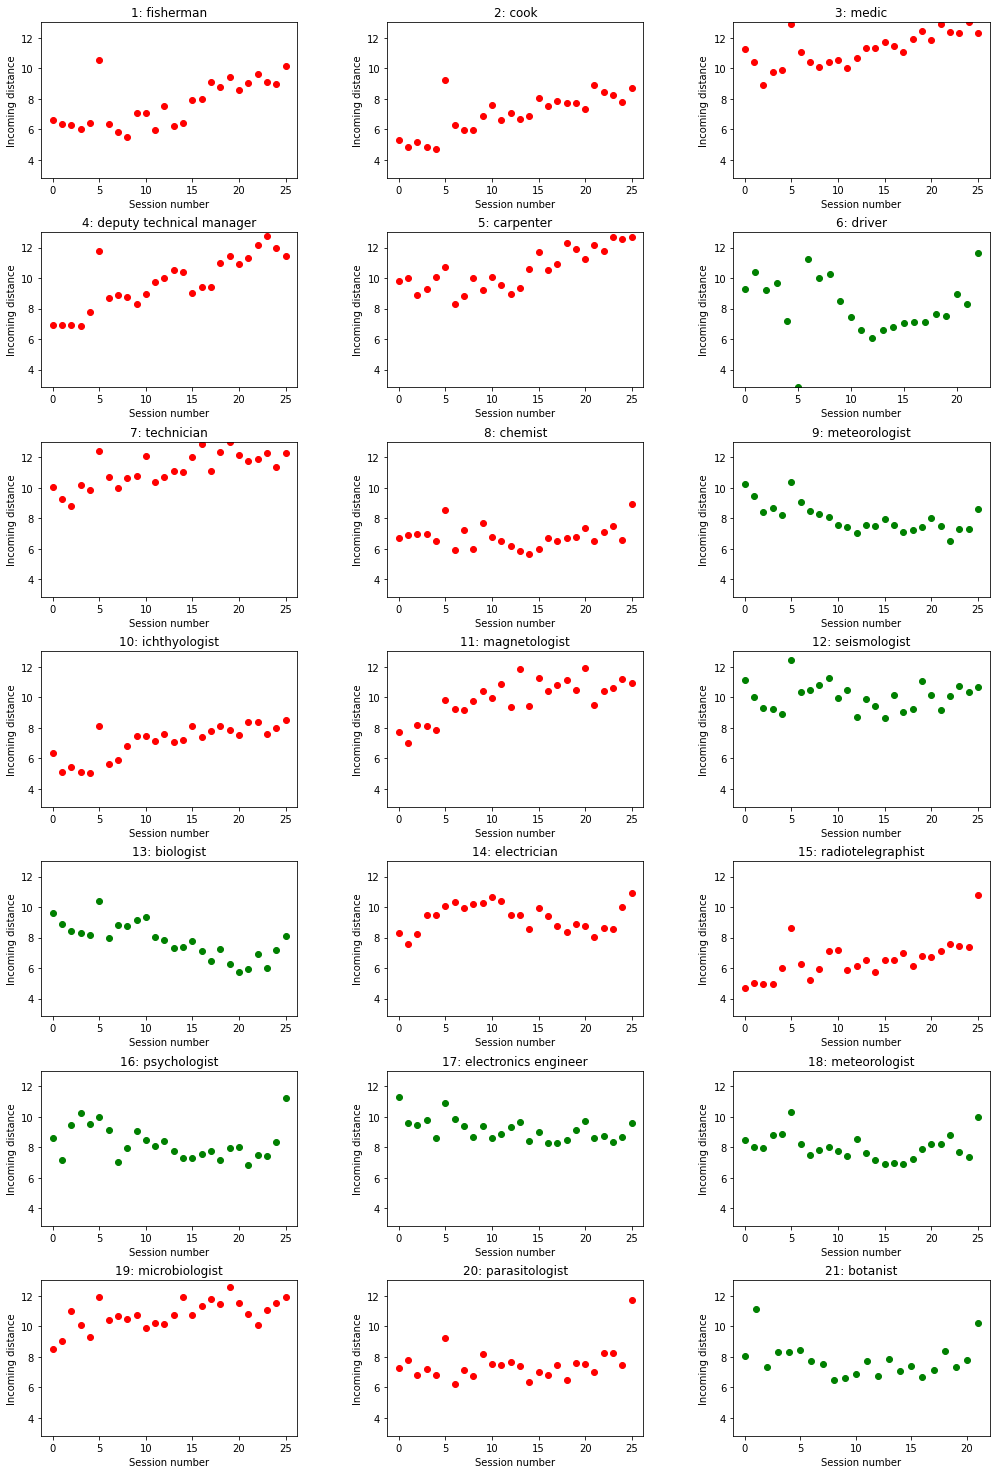

In [15]:
find_max = max([max(el) for el in average_incoming_distance_per_session_per_man])
find_min = min([min(el) for el in average_incoming_distance_per_session_per_man])
matplotlib.pyplot.figure(figsize=(17, 26))
plot_rows_no = 7
plot_cols_no = 3

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    matplotlib.pyplot.ylabel("Incoming distance")
    matplotlib.pyplot.xlabel("Session number")
    plot_color = 'go' if average_incoming_distance_slope_per_man[man][0] < 0 else 'ro'
    matplotlib.pyplot.plot(average_incoming_distance_per_session_per_man[man - 1], plot_color) # -1 since I index plot_ppl from 0    
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.subplots_adjust(hspace=0.35, wspace=0.35)
print("Let me draw the charts showing how incoming average distances changed over time for each person:")
matplotlib.pyplot.show()

<b>These are insights</b> I see after looking on the charts: <br>
    <ul>
    <li>Something happened around session no. 5 - that is between 11.02.79 and 27.02.79 It affected one's both outgoing and incoming relations</li>
    <li>People were consistent in their reports.</li>
    <li>There are significant differences between how people view others and how they were seen.</li>
    </ul>
<br>
Botanist have some data missing for first 4 sessions, that's why we see only 21 records on the chart.

## 7. Let me create wieghted graphs of relations, one for each session:

In [16]:
session_graphs = {x: networkx.MultiGraph() for x in sorted_filenames.keys()}
for n, session_graph in session_graphs.items():
    session_graph.add_nodes_from(ppl_professions.keys())
    if n < 10:
        session_graph.remove_node(6)   # no. 6 got on site 25.04.79 -> present from session no. 10
    if n < 5:
        session_graph.remove_node(21)  # data is missing for sessions 1-4
    for man in session_graph.nodes():
        for other in session_graph.nodes():
                if man - 1 != other - 1:
                    the_weight = people_data[man - 1].distances[n][other - 1]   # -1 since i refer to lists, not dictionaries
                    if the_weight is not None:
                        session_graph.add_edge(man, other, weight=the_weight)

Example labeled graph from session 24


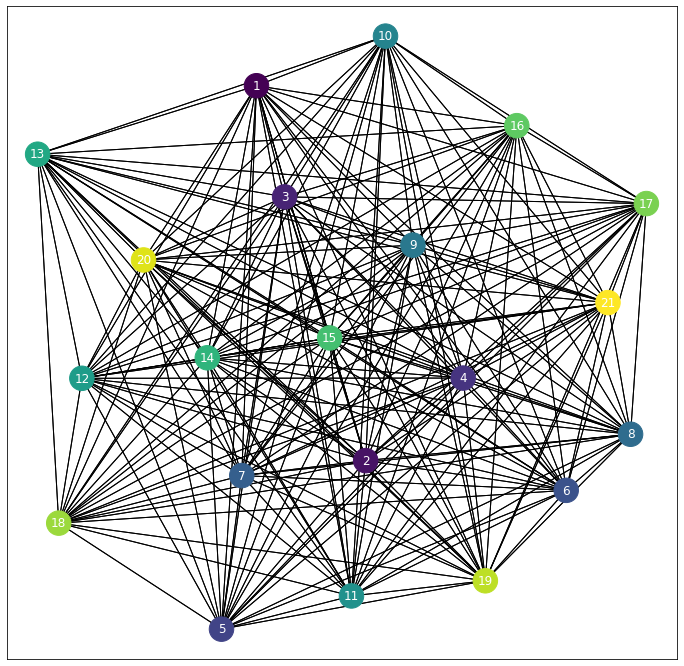

In [17]:
rand_session_1 = int(numpy.random.rand() * 26) + 1
print("Example labeled graph from session " + str(rand_session_1))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(session_graphs[rand_session_1], node_color=range(21), font_color='#ffffff', node_size=600)

Example labeled graph from session 19


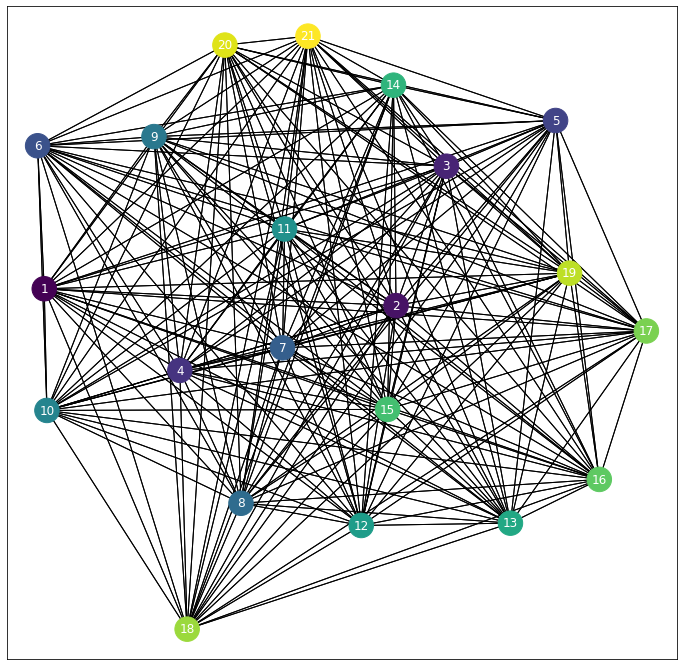

In [19]:
rand_session_2 = int(numpy.random.rand() * 26) + 1
print("Example labeled graph from session " + str(rand_session_2))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(session_graphs[rand_session_2], node_color=range(21), font_color='#ffffff', node_size=600)

##### Notice that edges (and thus nodes' ditances) are represented based on sum* of distances (from object Person) - that means, it's not only how particular person viewed others but also how he has been viewed by others - which is something different than I considered before as the mean. The mean was only the measure how particular person viewed others; not vice versa.

Both example graphs show that the cook (no. 2) was quite popular, even if himself viewed himself distanced (which is interesting).

*I know this from debugging the process of graph creation

## 8. How changed the graphs centrality over the sessions?
<a href="https://en.wikipedia.org/wiki/Closeness_centrality">Closeness centrality</a> of a node is the reciprocal of the average shortest path distance to considered node over all n-1 reachable nodes.
<br><br>
This means that the more central a node is, the closer it is to all other nodes - <a href="https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html">higher values of closeness indicate higher centrality</a>. On both above examples, node no. 2 is somewhat in the middle - it is closer to everybody than others are.

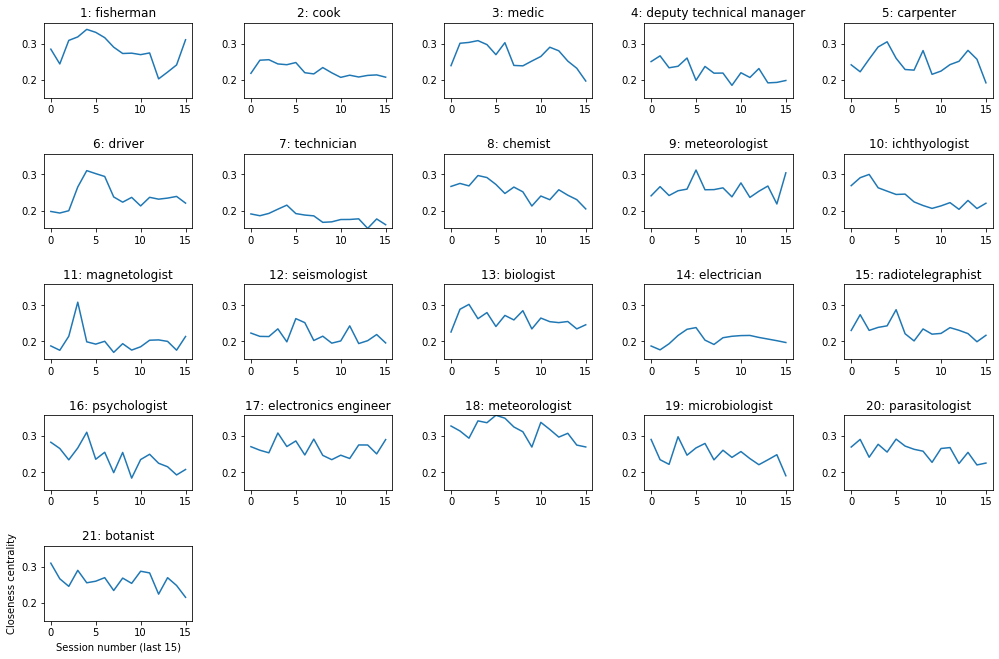

In [20]:
closeness_centrality_per_session = []
for session_graph in session_graphs.values():
    closeness_centrality_per_session.append(networkx.algorithms.centrality.closeness_centrality(session_graph, distance="weight"))

closeness_by_man =  {n: [] for n in ppl_professions.keys()}
for man in closeness_by_man.keys():
    for session_no in range(10, 26):   # values considered from session no. 10, when everybody was on site
        closeness_by_man[man].append(closeness_centrality_per_session[session_no][man])
        
find_max = max([max(el) for el in closeness_by_man.values()])
find_min = min([min(el) for el in closeness_by_man.values()])
matplotlib.pyplot.figure(figsize=(17, 11))
plot_rows_no = 5
plot_cols_no = 5

for man in ppl_professions.keys():
    matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
    matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
    matplotlib.pyplot.plot(closeness_by_man[man]) # -1 since I index plot_ppl from 0
    matplotlib.pyplot.ylim(find_min, find_max)

matplotlib.pyplot.ylabel("Closeness centrality")
matplotlib.pyplot.xlabel("Session number (last 15)")
matplotlib.pyplot.subplots_adjust(hspace=0.75, wspace=0.35)

matplotlib.pyplot.show()

What is different about the above results is that they represent closeness - <b>not</b> previously calculated distance. The distance was a metric of how far one viewed others, but told nothing about how others see particular person.
Closeness is calculated on weigths as seen in example graphs - and those are sum of outgoing and incoming relation value (as calculated in object Person)

Please notice, charts show data only for last 15 sessions, since only then everybody was present (since driver's ariival on 10th session and missing data for botanist for 1-4th sessions).

In [21]:
cumulative_centrality_per_session = {n: 0 for n in ppl_professions.keys()}
for session in closeness_centrality_per_session:
    for i, value in session.items():
        cumulative_centrality_per_session[i] += value
sorted_cumulative_centrality_per_session = {k: v for k, v in sorted(cumulative_centrality_per_session.items(), key=lambda item: item[1])}
print("Sorted cumulative centrality per session: ")
print()
for key, value in sorted_cumulative_centrality_per_session.items():
    print(f"{ppl_professions[key]:25} | {value:8.4f}")

Sorted cumulative centrality per session: 

driver                    |   3.9698
magnetologist             |   5.6983
botanist                  |   5.7109
technician                |   5.7621
electrician               |   5.7897
seismologist              |   6.1222
radiotelegraphist         |   6.6511
cook                      |   6.6646
deputy technical manager  |   6.6786
psychologist              |   6.8073
carpenter                 |   6.8403
ichthyologist             |   6.9435
chemist                   |   6.9484
meteorologist             |   6.9498
parasitologist            |   7.0858
microbiologist            |   7.1818
electronics engineer      |   7.3665
fisherman                 |   7.6226
biologist                 |   7.7535
medic                     |   7.9417
meteorologist             |   7.9472


## 9. Let me create a summary graph, based on mean weigths for all sessions' relations.

In [22]:
people_no = 21   # number of people
session_no = 26   # number of sessions
mean_weight_per_man = {n + 1: [[0 for p in range(session_no)] for s in range(people_no)] for n in range(people_no)} # people_no-1 since I skip self-relation
counter = 0
for i, graph in session_graphs.items():
    for edge in graph.edges.data("weight", default=True):
        counter += 1
        man_no = edge[0]
        other_no = edge[1]
        distance = edge[2]
        if counter % 2 != 0:   # edges are assembled by networkx in this way
            mean_weight_per_man[man_no][other_no - 1][i - 1] = distance
        else:
            mean_weight_per_man[other_no][man_no - 1][i - 1] = distance

# get mean distances between people for all sessions:
for man_no in mean_weight_per_man.keys():
    others_list = mean_weight_per_man[man_no]
    for list_no in range(len(others_list)):
        mean_weight_per_man[man_no][list_no] = numpy.mean(mean_weight_per_man[man_no][list_no])

# create summary graph:
summary_graph = networkx.MultiGraph()
summary_graph.add_nodes_from(mean_weight_per_man.keys())
for man in summary_graph.nodes():
    for other in summary_graph.nodes():
        if man != other:
            summary_graph.add_edge(man, other, weight=mean_weight_per_man[man][other - 1])

##### Let's plot the summary graph

The graph represents mean distance across all sessions. Please notice that each edge representing the distance is itself an 
average of the incoming and outgoing distance from a person (average of how a particular man view other man and how the other view the first).

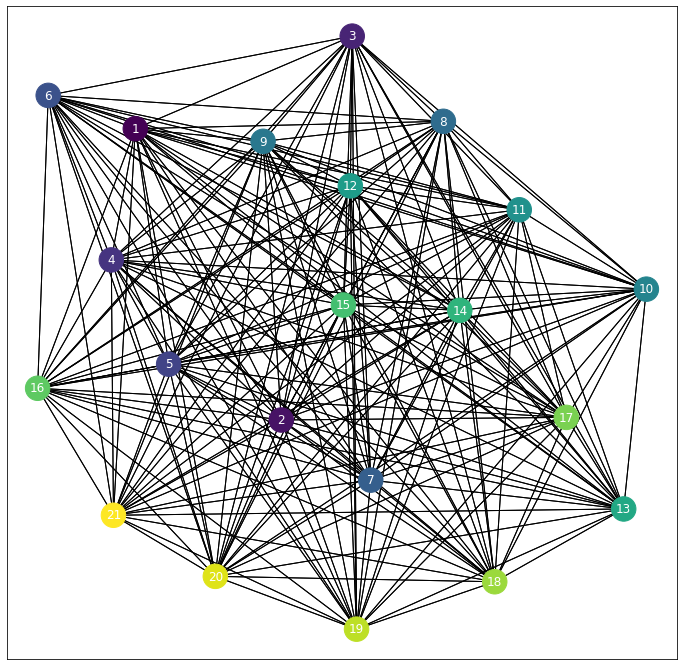

In [23]:
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(summary_graph, node_color=range(21), font_color='#ffffff', node_size=600)

Consistently I can see 2 (cook), 12 (seismologist) and 15 (radiotelegraphist) closer to every other.
This however <i><b>might</b></i> mean that they were 'average neutral' and not belonging to any social group (community), distancing equally to every other.

This brings me to the topic of groups, substantially hard since "the main elements of the problem themselves, i. e. the concepts of community and partition, are not rigorously defined, and require some degree of arbitrariness and/or common sense." as is written by Santo Fortunato in "Community detection in graphs" from 25.01.2010 (https://arxiv.org/abs/0906.0612)

## 10. What groups did people created, if any?

The topic of groups and identifying them is hard since not only its not well defined, but also there are many misconceptions and ambiguous word use.<br>
By goup I understand <a href="https://en.wikipedia.org/wiki/Social_group">social group</a>, not subject of <a href="https://en.wikipedia.org/wiki/Group_(mathematics)">group theory</a> nor a <a href="https://en.wikipedia.org/wiki/Clique_(graph_theory)">clique</a>.

<b>People can be part of more than one group at a time.</b> They can also switch groups - this is fascinating but does not help to grasp the nature of events.

I'll define a group as a number of people with closer distanse (both incoming and outgoing) to each other than the global average. I'll see what groups could be found, and what other if I redefine the distance condition to be closer by a one standard deviation of the global average distance.

Average distance for all relations in all sessions: 7.877047409060546
Average standard deviation for all relations in all sessions: 3.0828136555187333

Example graph of groups from session 3


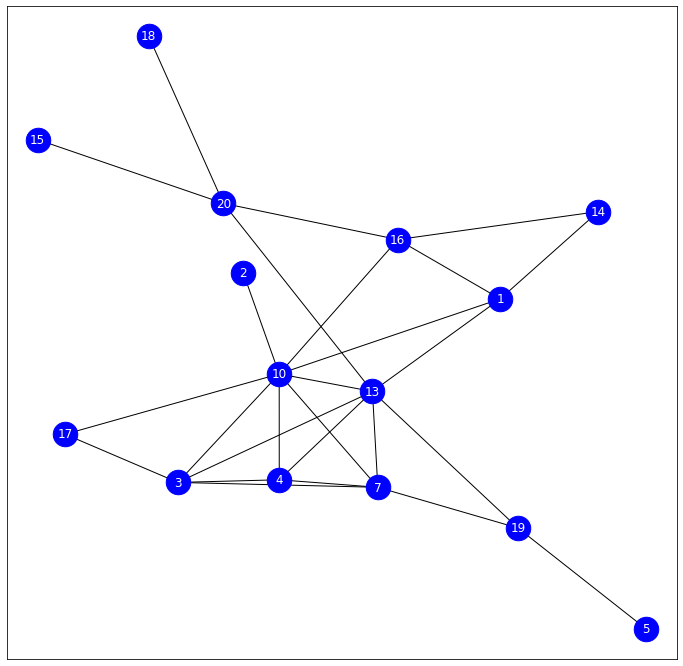

In [24]:
total_average = numpy.mean([numpy.mean(man) for man in mean_weight_per_man.values()])
print("Average distance for all relations in all sessions: " + str(total_average))

total_std = numpy.std([numpy.mean(man) for man in mean_weight_per_man.values()])
print("Average standard deviation for all relations in all sessions: " + str(total_std))
print()   # newline

# I'll save all relations considered by me as close enough - with distance smaller than one standard deviation below global average
session_groups_data = []
for i, graph in session_graphs.items():
    for edge in graph.edges.data("weight", default=True):
        man_no = edge[0]
        other_no = edge[1]
        distance = edge[2]
        if distance < (total_average - total_std):
            session_groups_data.append((i, man_no, other_no, distance))

# Lets filter out non-mutual relations
mutual_close_relations = []
for i in range(len(session_groups_data) - 1):
    if session_groups_data[i][0] == session_groups_data[i + 1][0]:   # if seesion is the same
        if session_groups_data[i][1] == session_groups_data[i + 1][1]:
            if session_groups_data[i][2] == session_groups_data[i + 1][2]:   # if men are saved twice meaning relation is mutual
                session_no = session_groups_data[i][0]
                man_no = session_groups_data[i][1]
                other_no = session_groups_data[i][2]
                distance = (session_groups_data[i][3] + session_groups_data[i + 1][3]) / 2   # let me save average distance
                mutual_close_relations.append((session_no, man_no, other_no, distance))

mutual_close_relations_graphs = {s + 1: networkx.MultiGraph() for s in range(session_no)}
for relation in mutual_close_relations:
    session_no = relation[0]
    man_no = relation[1]
    other_no = relation[2]
    distance = relation[3]
    mutual_close_relations_graphs[session_no].add_node(man_no)
    mutual_close_relations_graphs[session_no].add_node(other_no)
    mutual_close_relations_graphs[session_no].add_edge(man_no, other_no, weight=distance)
    
rand_session = int(numpy.random.rand() * 26) + 1
print("Example graph of groups from session " + str(rand_session))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(mutual_close_relations_graphs[rand_session], node_color='#0000ff', font_color='#ffffff', node_size=600)

Example graph of groups from session 3


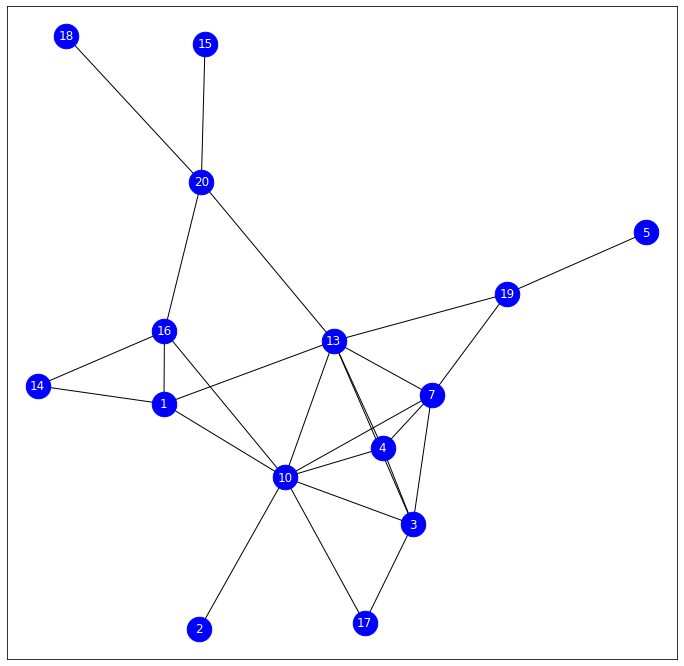

In [25]:
rand_session = int(numpy.random.rand() * 26) + 1
print("Example graph of groups from session " + str(rand_session))
matplotlib.pyplot.figure(figsize=(12,12)) 
networkx.draw_networkx(mutual_close_relations_graphs[rand_session], node_color='#0000ff', font_color='#ffffff', node_size=600)

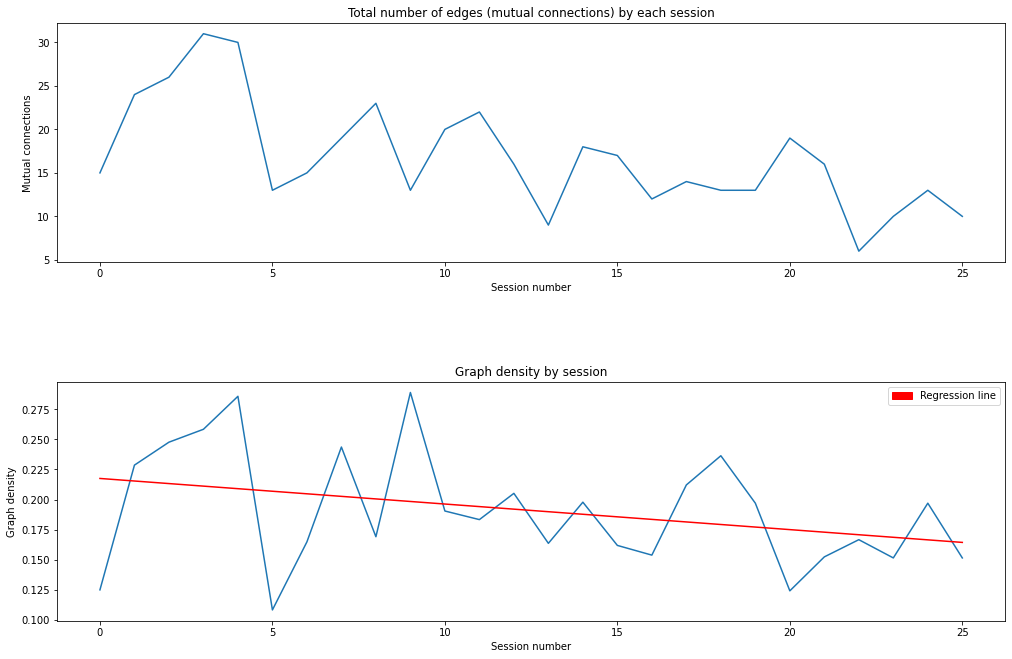

In [26]:
edges_no_by_session = []
density_by_session = []
for graph in mutual_close_relations_graphs.values():
    edges_no_by_session.append(networkx.classes.function.number_of_edges(graph))
    density_by_session.append(networkx.classes.function.density(graph))

x = range(len(density_by_session))
m, b = numpy.polyfit(x, density_by_session, 1)
    
matplotlib.pyplot.figure(figsize=(17, 11))
matplotlib.pyplot.subplot(2, 1, 1)
matplotlib.pyplot.title("Total number of edges (mutual connections) by each session")
matplotlib.pyplot.ylabel("Mutual connections")
matplotlib.pyplot.xlabel("Session number")
matplotlib.pyplot.plot(edges_no_by_session)
matplotlib.pyplot.subplot(2, 1, 2)
matplotlib.pyplot.title("Graph density by session")
matplotlib.pyplot.ylabel("Graph density")
matplotlib.pyplot.xlabel("Session number")
matplotlib.pyplot.plot(density_by_session)
matplotlib.pyplot.plot(x, m*x + b, color="#ff0000")
density_legend = patches.Patch(color="#ff0000", label="Regression line")
matplotlib.pyplot.legend(handles=[density_legend])

matplotlib.pyplot.subplots_adjust(hspace=0.5, wspace=0.35)

matplotlib.pyplot.show()

<a href="https://en.wikipedia.org/wiki/Dense_graph">Graph density</a> is a ratio of the number of edges to the number of vertices in the graph - maximal density is 1 and the minimal density is 0 (max density of 1 when all vertices are connected with each other).<br>
Interesting observation is that the number of mutual relations was getting smaller with passing time (however this fits with previous insights).<br>
There is also a visible confirmation of impactful event just before session number 5.<br><br>
I can see some oscilating variation from session to session, but is it relevant?

In [27]:
print("Total number of edges by each session: ")
print(edges_no_by_session)
print("Standard deviation of above's numbers of edges: " + str(numpy.std(edges_no_by_session)))
difference_edges_no_by_session = []
for i in range(len(edges_no_by_session) - 1):
    difference_edges_no_by_session.append(edges_no_by_session[i+1] - edges_no_by_session[i])
print()   # newline
print("Differences between consecutive edges' numbers: ")
print(difference_edges_no_by_session)

Total number of edges by each session: 
[15, 24, 26, 31, 30, 13, 15, 19, 23, 13, 20, 22, 16, 9, 18, 17, 12, 14, 13, 13, 19, 16, 6, 10, 13, 10]
Standard deviation of above's numbers of edges: 6.139526608969825

Differences between consecutive edges' numbers: 
[9, 2, 5, -1, -17, 2, 4, 4, -10, 7, 2, -6, -7, 9, -1, -5, 2, -1, 0, 6, -3, -10, 4, 3, -3]


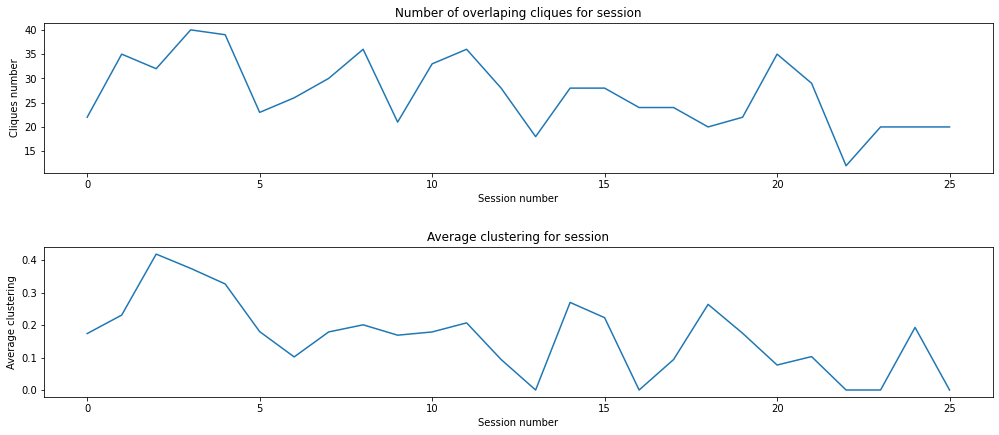

In [28]:
overlaping_no_cliques_for_session = []
for g in mutual_close_relations_graphs.values():
    overlaping_no_cliques_for_session.append(sum(networkx.algorithms.clique.number_of_cliques(g).values()))

import networkx.algorithms.approximation as approximation
average_clustering_for_session = []
for g in mutual_close_relations_graphs.values():
    average_clustering_for_session.append(approximation.clustering_coefficient.average_clustering(g))

matplotlib.pyplot.figure(figsize=(17, 11))
matplotlib.pyplot.subplot(3, 1, 1)
matplotlib.pyplot.title("Number of overlaping cliques for session")
matplotlib.pyplot.ylabel("Cliques number")
matplotlib.pyplot.xlabel("Session number")
matplotlib.pyplot.plot(overlaping_no_cliques_for_session)
matplotlib.pyplot.subplot(3, 1, 2)
matplotlib.pyplot.title("Average clustering for session")
matplotlib.pyplot.ylabel("Average clustering")
matplotlib.pyplot.xlabel("Session number")
matplotlib.pyplot.plot(average_clustering_for_session)

matplotlib.pyplot.subplots_adjust(hspace=0.5, wspace=0.35)

matplotlib.pyplot.show()

Above there are plots for the change of the number of maximal <a href="https://en.wikipedia.org/wiki/Clique_(graph_theory)">cliques</a> for each node by session, and for average <a href="https://en.wikipedia.org/wiki/Clustering_coefficient">clustering</a> by session.

## 11. Who was most infuential among the men?
By <a href="https://en.wikipedia.org/wiki/Social_influence">influence</a> I understand a simple number of mutual connections (as previously defined). The most influential man would have the most mutual connections - best relations with the most other men. In fact, this does not necessarily mean he <i> was influential</i> - he could just be most open and friendly to others.

In [29]:
# ordered list of men by number of mutual relations each session
sessions_by_man_influence = {session: [] for session in range(1, session_no + 1)}
for i, graph in mutual_close_relations_graphs.items():
    for man in ppl_professions.keys():
        if graph.has_node(man):
            count = 0
            for node in graph.nodes():
                if graph.number_of_edges(man, node):
                    count += 1
            sessions_by_man_influence[i].append(count)
        else:
            sessions_by_man_influence[i].append(0)
            
list_of_influencers = []
for no, men in sessions_by_man_influence.items():
    max_influence = max(men)
    position = []
    for i, relations_no in enumerate(men):
        if relations_no == max_influence:
            position.append(i)
    ppl = [ppl_professions[x + 1] for x in position]
    list_of_influencers.append(ppl)
    if no < 10:
        print("For session no.  " + str(no) + " most influential were: " + str(ppl))
    else:
        print("For session no. " + str(no) + " most influential were: " + str(ppl))
        
count_total_influence_by_man = {man: 0 for man in ppl_professions.keys()}
for session in list_of_influencers:
    for man in count_total_influence_by_man.keys():
        if ppl_professions[man] in session:
            count_total_influence_by_man[man] += 1
print()   # newline
sorted_count_total_influence_by_man = {k: v for k, v in sorted(count_total_influence_by_man.items(), key=lambda item: item[1], reverse=True)}
for man_no, value in sorted_count_total_influence_by_man.items():
    print(f"{ppl_professions[man_no]:25} | {value:3d}")

For session no.  1 most influential were: ['deputy technical manager', 'biologist']
For session no.  2 most influential were: ['ichthyologist']
For session no.  3 most influential were: ['ichthyologist']
For session no.  4 most influential were: ['ichthyologist']
For session no.  5 most influential were: ['ichthyologist', 'biologist', 'microbiologist']
For session no.  6 most influential were: ['seismologist']
For session no.  7 most influential were: ['biologist']
For session no.  8 most influential were: ['carpenter', 'biologist']
For session no.  9 most influential were: ['biologist']
For session no. 10 most influential were: ['carpenter', 'biologist', 'electronics engineer']
For session no. 11 most influential were: ['meteorologist']
For session no. 12 most influential were: ['parasitologist']
For session no. 13 most influential were: ['biologist']
For session no. 14 most influential were: ['psychologist']
For session no. 15 most influential were: ['carpenter', 'biologist']
For ses

The biologist outperformed everybody in making relationships (relationships as defined previously).

Knowing who was <i>the most</i> influential may not be as informative as I would want, especially in context of telling how persistent groups were. For example, several times in a row ichthyologist was most infuential and this abruptly stopped since session no. 5 - he didn't showed on the lists thereafter.<br>
Let me list all men ordered by the number of consistently having a 2+ mutual relations from session to session. By this I want to have a new insight on being influential before diving in to group pesristence. For example, one could have "low" influence by maintaining a single clique relation - but this relation would endure for nearly all sessions.

In [42]:
consistent_man_influence_by_session = {man: [] for man in ppl_professions.keys()}
men = range(0, 21)
sessions = range(0, 26)

for man in men:
    for session in sessions:
        if sessions_by_man_influence[session + 1][man] > 1:
            consistent_man_influence_by_session[man + 1].append(1)
        else:
            consistent_man_influence_by_session[man + 1].append(0)
            
for man in men:
    for session in sessions:
        if consistent_man_influence_by_session[man + 1][session] != 0:
            consistent_man_influence_by_session[man + 1][session] = session + 1

consistent_session_influence_by_man = {man: [] for man in ppl_professions.keys()}
for man in men:
    starts_list = []
    ends_list = []
    for session in sessions[1:-1]:
        previous = consistent_man_influence_by_session[man + 1][session - 1]
        current = consistent_man_influence_by_session[man + 1][session]
        consequent = consistent_man_influence_by_session[man + 1][session + 1]
        # edge cases
        if session - 1 == 0:
            if previous != 0 and current != 0:
                starts_list.append(previous)
        if session + 1 == sessions[-1]:
            if current != 0 and consequent != 0:
                ends_list.append(consequent)
        # standard cases
        if previous == 0 and current != 0 and consequent != 0:
            starts_list.append(current)
        if previous != 0 and current != 0 and consequent == 0:
            ends_list.append(current) 
    consistent_session_influence_by_man[man + 1] = [(x, y) for x, y in zip(starts_list, ends_list)]

def tuple_list_to_string(entry: list) -> str:
    output = ""
    for elem in entry:
        output += str(elem[0]) + "-" + str(elem[1]) + ", "
    return output

print("Men with session ranges in which they had 2 or more reciprocal relations: ")
for man, sessions in consistent_session_influence_by_man.items():
    print(f"{ppl_professions[man]:25} | {tuple_list_to_string(sessions)}")

Men with session ranges in which they had 2 or more reciprocal relations: 
fisherman                 | 2-5, 7-9, 11-14, 17-22, 
cook                      | 
medic                     | 1-9, 12-13, 15-18, 20-21, 
deputy technical manager  | 1-10, 12-13, 
carpenter                 | 4-6, 8-13, 15-16, 
driver                    | 15-16, 18-26, 
technician                | 1-6, 
chemist                   | 
meteorologist             | 
ichthyologist             | 1-5, 8-9, 11-13, 
magnetologist             | 
seismologist              | 
biologist                 | 1-5, 7-22, 
electrician               | 19-22, 
radiotelegraphist         | 18-22, 
psychologist              | 2-5, 7-12, 14-17, 
electronics engineer      | 2-13, 15-16, 21-22, 
meteorologist             | 8-9, 11-22, 24-26, 
microbiologist            | 1-5, 7-13, 
parasitologist            | 1-5, 8-10, 
botanist                  | 11-12, 21-22, 24-26, 


Above listing is interesting since it appears people who were never <i>most</i> influential maintained stable relations.
For example, deputy technical manager was only once the most infuential man, however he maintained reciprocal relation from session one to 10 and also from session 12 to 13.

## 12. Group persistence index

## 13. How influence shaped and how was it connected to input data patterns?

In [31]:
# TODO

## 14. How one's view about others shaped the view others had about him?

Pearson's standard correlation coefficient: 

fisherman                 | -0.162
cook                      |  0.464
medic                     |  0.148
deputy technical manager  |  0.398
carpenter                 |  0.133
driver                    |  0.267
technician                |  0.240
chemist                   |  0.227
meteorologist             | -0.626
ichthyologist             |  0.554
magnetologist             | -0.605
seismologist              | -0.436
biologist                 |  0.035
electrician               | -0.109
radiotelegraphist         |  0.163
psychologist              |  0.080
electronics engineer      | -0.012
meteorologist             |  0.191
microbiologist            |  0.323
parasitologist            |  0.296
botanist                  |  0.105

Average correlation coefficient: 0.07974138481835695



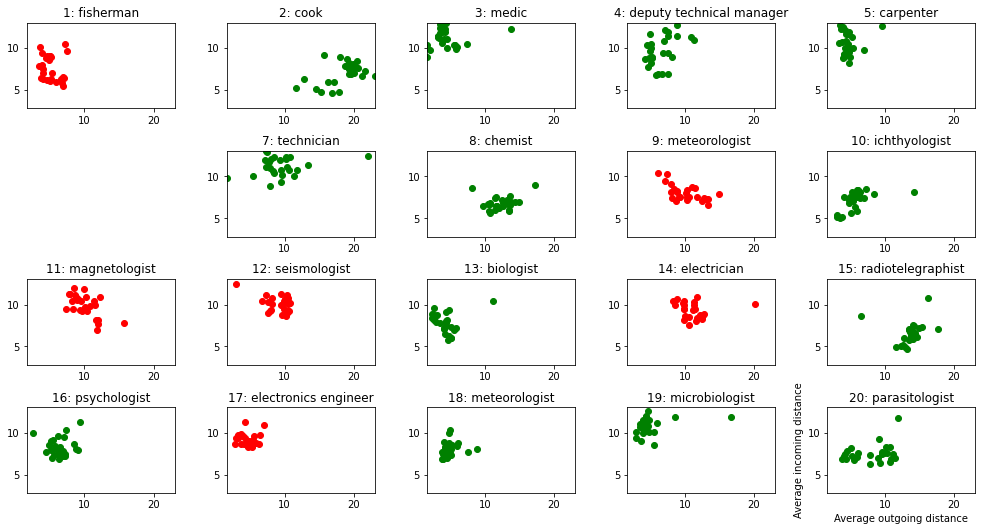

In [32]:
print("Pearson's standard correlation coefficient: ")
print()   # newline
correlations = []
correlation_info = []
for man in range(people_no):
    x = pandas.Series(mean_distances_for_man[man])
    y = pandas.Series(average_incoming_distance_per_session_per_man[man])
    correlations.append(x.corr(y))
    #correlation_info.append(linregress(x, y))
for i, coef in enumerate(correlations):
    print(f"{ppl_professions[i + 1]:25} | {coef:>6.3f}")
    
print()   # newline
print("Average correlation coefficient: " + str(numpy.mean(correlations)))
print()   # newline

matplotlib.pyplot.figure(figsize=(17, 11))
plot_rows_no = 5
plot_cols_no = 5

y_find_max = max([max(el) for el in average_incoming_distance_per_session_per_man])
y_find_min = min([min(el) for el in average_incoming_distance_per_session_per_man])
x_find_max = max([max(el) for el in mean_distances_for_man])
x_find_min = min([min(el) for el in mean_distances_for_man])
for man in ppl_professions.keys():
    if man != 6 and man != 21:
        matplotlib.pyplot.subplot(plot_rows_no, plot_cols_no, man)
        matplotlib.pyplot.title(str(man) + ": " + ppl_professions[man])
        matplotlib.pyplot.ylim(y_find_min, y_find_max)
        matplotlib.pyplot.xlim(x_find_min, x_find_max)
        plot_color = 'go' if correlations[man - 1] > 0 else 'ro'
        matplotlib.pyplot.plot(mean_distances_for_man[man - 1], average_incoming_distance_per_session_per_man[man - 1], plot_color)

matplotlib.pyplot.ylabel("Average incoming distance")
matplotlib.pyplot.xlabel("Average outgoing distance")
matplotlib.pyplot.subplots_adjust(hspace=0.5, wspace=0.35)

matplotlib.pyplot.show()

On above plots, outgoing relations marks (X) are matched with incoming relations (Y).<br>
Notice that even if this data is related to time (measurements taken during sessions) charts do not take order into consideration.
The charts simply make a dot in place where value of outgoing relation where matched by value of incoming relation.
Dots are colored green if correlation coefficient is positive or red otherwise.
For example, the perfect positive correlation would be observed if one's distances were closer to each other by each session (like magnetologist's), and in the same time everybody would mark him as a closer one - in reality it was exactly opposite. Elaborating the magnetologist's case: the more he viewed others close to him, others view him more distanced away.

There are missing charts for driver and for botanist since part of their data is missing.

Visible outlier is relevant to almost every chart - worth checking is if the outlier is coming from session no. 5 (with disturbing event).

## 15. A look on statistical significances

I have manipulated the data and made some statements about the outcomes:<br>
&nbsp;&nbsp;&nbsp;&nbsp;<i>from section 3</i><br>
"Average change for mean distance slope is slighty positive, suggesting people felt more distant over time."<br>
"Average change for average incoming distance slope is  0.0445"<br>
"People were consistent in their reports."<br>
"There are significant differences between how people view others and how they were seen."<br>

&nbsp;&nbsp;&nbsp;&nbsp;<i>from section 6</i><br>
"Graph centrality lowered with each session."<br>

&nbsp;&nbsp;&nbsp;&nbsp;<i>from section 8</i><br>
"Number of mutual connections was falling with passing time."<br>

&nbsp;&nbsp;&nbsp;&nbsp;<i>from section 10</i><br>
"In general when people viewed others as closer to themselves, they were also viewed as closer by others"<br>

&nbsp;&nbsp;&nbsp;&nbsp;<i>general</i><br>
"There was an important event between sessions 4 and 5"<br>

Now I want to verify those claims by refering to statistical significance.

In [33]:
#   TODO

## 16. Speculation: space mission predictions

In [34]:
# TODO

## 17. Summary and insights

I've done what I believe is a summary statistics about the data I received.
The data pertains to human subjective view of relations between small group of people staying in difficult conditions over the many months.

I've transformed the data from information about points coordinates marked on charts to distances. This unfortunatelly has caused the loss about the plausible patterns people used to mark their opinions.
With the distances organised by people by sessions, I've lookod how those changed through time, I've created sample graphs of parallel (and mutual) relations and used the graphs to get closeness centralities. Finally I've plotted graph defined by mean closeness centralities across all sessions, and peeked into possible groups of people.

My insights are:
<ul>
    <li>There was an important event between sessions no. 4 and 5. Majority of people felt more distanced from others afterwards.</li>
    <li>There is an important difference between how one view others, and how other view particular person - these however needs further investigation and consulting statistical importance.</li>
    <li> People were consistent in their answers - it is worth checking other variables, like psychology test filled before the journey to Antarctics.</li>
    <li> </li>
    </ul>